In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
from deepshape.surfaces import *
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import mse_loss

In [3]:
class Logger:
    def __init__(self, interval):
        self.interval = interval
        self.start()
        
    def start(self):
        self.tic = time.time()
            
    def stop(self):
        self.toc = time.time()
        print()
        print(f'Finished training in {self.toc - self.tic:.5f}s')
        
    def log(self, it, value):
        if self.interval > 0 and it % self.interval == 0:
            print('[Iter %5d] loss: %.5f' % (it + 1, value))

class Silent(Logger):
    def __init__(self):
        super().__init__(0)

In [14]:
class ShapeDistance(nn.Module):
    def __init__(self, q, r, k=32):
        super().__init__()
        self.q = q
        self.r = r
        self.counter = 1
        self.k = 2 ** (self.counter + 1)
        self.X = torch_square_grid(k).reshape(-1, 2)
        
             
    def forward(self, network, h=1e-4):
        Y = network(self.X)
        U = batch_determinant(network.derivative(self.X, h))
        loss = mse_loss(self.q(self.X), torch.sqrt(U) * self.r(Y)) / 3.
        
#         self.counter = (self.counter + 1) % 5
#         k = 2 ** (self.counter + 1)
#         self.X = torch_square_grid(k).reshape(-1, 2)
#         print(k)

        
        return loss

In [15]:
def partial_differences(f, x, component, h=1e-4):
    dx = torch.zeros_like(x)
    dx[..., component] = h
    return (0.5 / h) * (f(x + dx) - f(x - dx))


def jacobian(f, x, h=1e-4):
    dxf = partial_differences(f, x, 0, h=1e-4)
    dyf = partial_differences(f, x, 1, h=1e-4)
    return torch.stack((dxf, dyf), dim=-1)


class DeepShapeLayer(nn.Module, ABC):
    @abstractmethod
    def forward(self, x):
        pass
    
    def derivative(self, x, h=1e-4):
        return jacobian(self, x)
    
    @abstractmethod
    def project(self):
        pass

In [16]:
class FourierLayer(DeepShapeLayer):
    def __init__(self, n, init_scale=0.):
        super().__init__()

        # Basis Size related numbers
        self.nvec = torch.arange(1, n+1)
        self.n = n
        self.N = 2 * n**2 + n
        
        # Upsampler required in forward pass
        self.upsample = nn.Upsample(scale_factor=n, mode='nearest')

        # Create weight vector
        self.weights = torch.nn.Parameter(
            init_scale * torch.randn(2*self.N, requires_grad=True)
        )

        
    def forward(self, x):
        """Assumes input on form (K, 2)"""
        K = x.shape[0]
        n, N = self.n, self.N
        z = (x.view(K, 2, 1) * self.nvec)
        
        # Sine matrices
        S1 = torch.sin(pi * z)
        S2 = torch.sin(2 * pi * z)[:, (1, 0), :]
        
        # Cosine matrices
        C1 = torch.cos(pi * z)
        C2 = torch.cos(2 * pi * z)[:, (1, 0), :]
        
        # Tensor product matrices.
        T2 = self.upsample(S1) * S2.repeat(1, 1, n)
        T3 = self.upsample(S1) * C2.repeat(1, 1, n)

        # Function output tensor
        self.B = torch.zeros(K, 2, 2*N)

        self.B[:, 0, :n] = S1[:, 0, :]  # Type 1 x direction
        self.B[:, 1, N:(N+n)] = S1[:, 1, :]  # Type 1  y-direction

        self.B[:, 0, n:(n**2+n)] = T2[:, 0, :]  #Type 2 x-direction
        self.B[:, 1, (N+n):(N + n**2 + n)] = T2[:, 1, :]  # Type 2 y-direction

        self.B[:, 0, (n+n**2):N] = T3[:, 0, :]  # Type 3 x-direction
        self.B[:, 1, (N+n+n**2):] = T3[:, 1, :]  # Type3 y-direction

        return x + self.B @ self.weights
    
    
    def project(self, c=0.9):
        self.weights *= c / self.weights.norm()

In [17]:
class PalaisLayer(DeepShapeLayer):
    def __init__(self, n, init_scale=0.):
        super().__init__()

        # Basis Size related numbers
        self.nvec = torch.arange(1, n+1)
        self.n = n
        self.N = 2 * n**2 + n
        
        # Upsampler required in forward pass
        self.upsample = nn.Upsample(scale_factor=n, mode='nearest')

        # Create weight vector
        self.weights = torch.nn.Parameter(
            init_scale * torch.randn(2*self.N, requires_grad=True)
        )

        
    def forward(self, x):
        """Assumes input on form (K, 2)"""
        K = x.shape[0]
        n, N = self.n, self.N
        z = (x.view(K, 2, 1) * self.nvec)
        
        # Sine matrices
        S1 = torch.sin(pi * z) / self.nvec
        S2 = torch.sin(2 * pi * z)[:, (1, 0), :] / self.nvec
        
        # Cosine matrices
        C1 = torch.cos(pi * z) / self.nvec
        C2 = torch.cos(2 * pi * z)[:, (1, 0), :] / self.nvec
        
        # Tensor product matrices.
        T2 = self.upsample(S1) * S2.repeat(1, 1, n)
        T3 = self.upsample(S1) * C2.repeat(1, 1, n)

        # Function output tensor
        self.B = torch.zeros(K, 2, 2*N)

        self.B[:, 0, :n] = S1[:, 0, :]  # Type 1 x direction
        self.B[:, 1, N:(N+n)] = S1[:, 1, :]  # Type 1  y-direction

        self.B[:, 0, n:(n**2+n)] = T2[:, 0, :]  #Type 2 x-direction
        self.B[:, 1, (N+n):(N + n**2 + n)] = T2[:, 1, :]  # Type 2 y-direction

        self.B[:, 0, (n+n**2):N] = T3[:, 0, :]  # Type 3 x-direction
        self.B[:, 1, (N+n+n**2):] = T3[:, 1, :]  # Type3 y-direction

        return x + self.B @ self.weights
    
    def project(self, c=0.9):
        with torch.no_grad():
            self.weights *= c / (np.pi * self.weights.norm())

In [18]:
class ReparametrizationNetwork(nn.Module):
    def __init__(self, layerlist):
        super().__init__()
        self.layerlist = layerlist
        for layer in layerlist:
            assert isinstance(layer, DeepShapeLayer), "Layers must inherit DeepShapeLayer"
        
    def forward(self, x):
        for layer in self.layerlist:
            x = layer(x)
        return x
    
    def derivative(self, x, h=1e-4):
        if h is not None:
            return torch.eye(2, 2) + jacobian(self, x, h)
        
        Df = torch.eye(2, 2)
        y = x
        for layer in self.layerlist:
            Df = layer.derivative(y) @ Df
            y = layer(y)
            
        return torch.eye(2, 2) + Df

    def project(self, **kwargs):
        with torch.no_grad():
            for module in self.modules():
                if isinstance(module, DeepShapeLayer):
                    module.project(**kwargs)

In [28]:
class ScheduledOptimizer():
    def __init__(self, optimizer, scheduler, *args, **kwargs):
        self.opt = optimizer
        self.sched = scheduler(self.opt, *args, **kwargs)
        
    def step(self):
        self.sched.step()
        self.step()

In [19]:
def numpy_nans(dim, *args, **kwargs):
    arr = np.empty(dim, *args, **kwargs)
    arr.fill(np.nan)
    return arr

In [ ]:
class BFGS_Optimizer:
    def __init__(self, loss):
        
        
        
        
    def closure(self):
        

In [38]:
def reparametrize(q, r, network, loss, optimizer, iterations, logger):
    # Evaluate initial error
    logger.start()
    error = numpy_nans(iterations+1)
    error[0] = loss(network)
    
    for i in range(iterations):
        # Zero gradient buffers
        optimizer.zero_grad()
        
        # Compute current loss and gradients
        l = loss(network)
        l.backward()
        
#         # Update optimizer if using scheduler
#         if scheduler is not None:
#             scheduler.step(l)
            
        # Update parameters
        optimizer.step()
        error[i+1] = l.item()
        network.project(X=X)

        logger.log(i, l)
    
    logger.stop()
    return error

In [47]:
def reparametrize(q, r, network, loss, optimizer, iterations, logger, scheduler=None):
    # Evaluate initial error
    logger.start()
    error = numpy_nans(iterations+1)
    error[0] = loss(network)
    i = 0
    
    def closure():
        # Zero gradient buffers
        optimizer.zero_grad()

        # Compute current loss and gradients
        l = loss(network)
        l.backward()
        error[i+1] = l.item()

        # Project network
        with torch.no_grad():
            network.project(c=0.9)

        logger.log(i, l)

        return l
    
    optimizer.step(closure)
    
    logger.stop()
    return error

In [48]:
network = ReparametrizationNetwork(nn.ModuleList([PalaisLayer(5), PalaisLayer(5), PalaisLayer(5)]))
optim = torch.optim.SGD(network.parameters(), lr=1e-4, momentum=0.5)
γ = LogStep_Quadratic
q = Qmap(CylinderWrap)
r = Qmap(CylinderWrap.compose(γ))
s = ShapeDistance(q, r, k=16)
X = torch_square_grid(16).reshape(-1, 2)

q(X)
r(X)
s(network)
network(X)

reparametrize(q, r, network, s, optim, 50, Logger(1))

[Iter     1] loss: 4.50129

Finished training in 0.08989s


array([4.50128984, 4.50128984,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

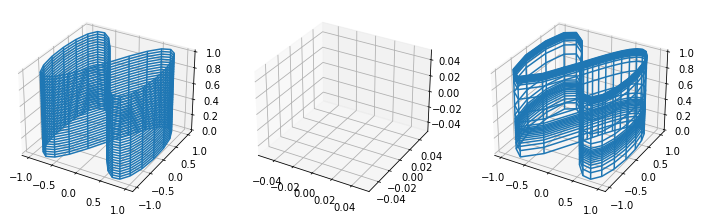

In [26]:
f = CylinderWrap.compose(network)
g = CylinderWrap.compose(γ)

Zf1 = get_plot_data(CylinderWrap)
Zf2 = get_plot_data(f)
Zg = get_plot_data(g)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131, projection='3d')
ax.plot_wireframe(*Zf1)
ax = fig.add_subplot(132, projection='3d')
ax.plot_wireframe(*Zf2)
ax = fig.add_subplot(133, projection='3d')
ax.plot_wireframe(*Zg)
plt.show()